In [52]:
#Bayesian Neural Network with Gaussian Prior and Likelihood

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Create a function for generating data
def hidden_function(x):
    return x + 0.3 * np.sin(2*np.pi*x) + 0.3*np.sin(4*np.pi*x)

In [2]:
# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = hidden_function(x_obs+noise)

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = hidden_function(x_true)

print(x_obs.shape, noise.shape, y_obs.shape, x_true.shape, y_true.shape)

(1000,) (1000,) (1000,) (1000,) (1000,)


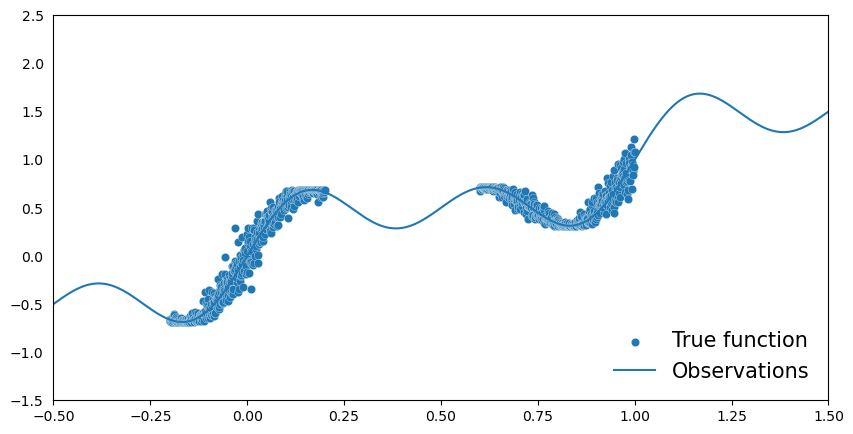

In [3]:
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=x_obs, y=y_obs, linewidth=0.2, label="True function")
sns.lineplot(x=x_true, y=y_true, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.tick_params(left=False)
ax.legend(loc=4, fontsize=15, frameon=False)
plt.show()

In [4]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


In [6]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Warmup:   0%|                                                                  | 0/100 [00:00, ?it/s]/home/jasmine/miniforge3/envs/uncertainty_quant/lib/python3.12/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|███████████████████████| 100/100 [01:58,  1.19s/it, step size=6.93e-04, acc. prob=0.929]


In [7]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [8]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    sns.lineplot(x=x_true, y=y_true, label="true function")
    sns.scatterplot(x=x_obs, y=y_obs, label="observations")
    sns.lineplot(x=x_test, y=y_pred, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

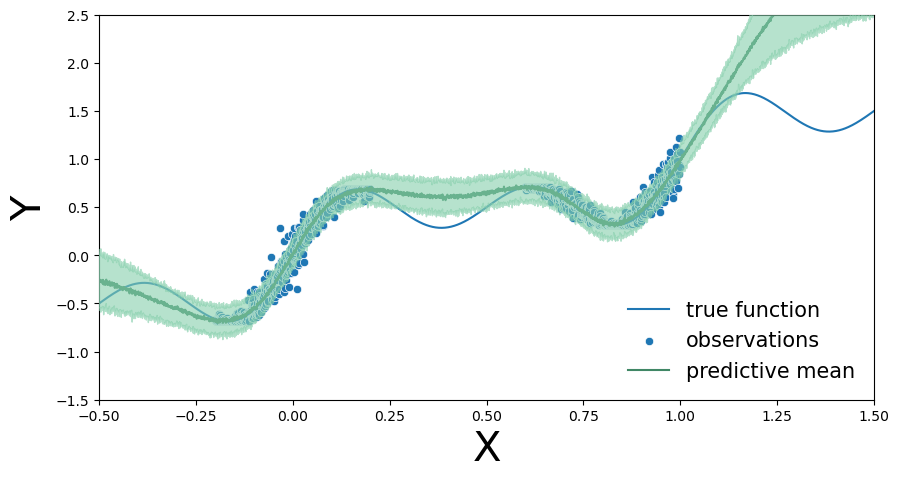

In [9]:
plot_predictions(preds)

In [47]:
x_eval = torch.linspace(-0.2, 1, 1000)
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_eval = hidden_function(x_eval+noise)

In [48]:
preds_eval = predictive(x_eval)
y_pred = preds_eval['obs'].T.detach().numpy().mean(axis=1)
y_std = preds_eval['obs'].T.detach().numpy().std(axis=1)

In [49]:
y_pred_upper = y_pred + 2*y_std
y_pred_lower = y_pred - 2*y_std

y_within_bounds = np.logical_and(y_pred_lower <= y_eval.numpy(), y_eval.numpy() <= y_pred_upper)
print("Fraction 95% CI:", y_within_bounds.mean())

Fraction 95% CI: 0.753


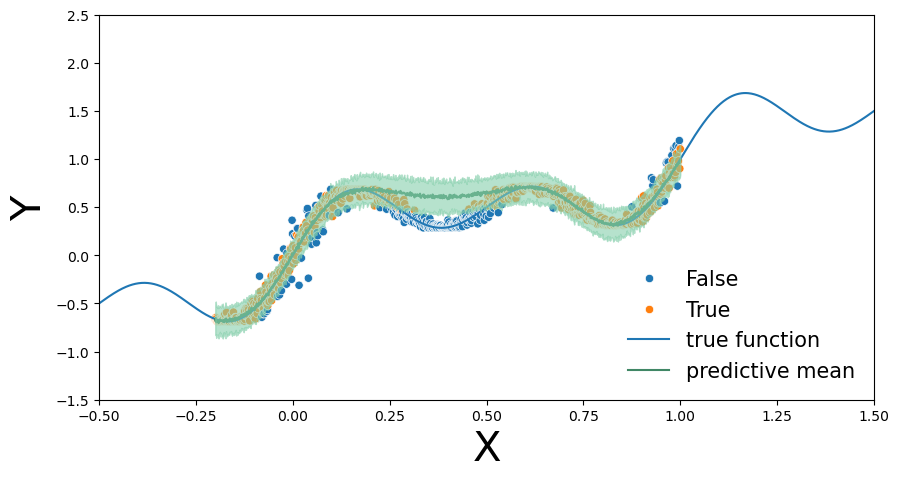

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)
sns.scatterplot(x=x_eval, y=y_eval, hue=y_within_bounds)
sns.lineplot(x=x_true, y=y_true, label="true function")
sns.lineplot(x=x_eval, y=y_pred, color="#408765", label="predictive mean")
ax.fill_between(x_eval, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False)